# Fragestellung 1.2: Wie viele EinwohnerInnen und Beschäftigte sind duch hohe Öl- und Gaspreise in einer Gemeinde betroffen?

Um diese Fragen zu beantworten, werden Daten aus dem "Gebäude- und Wohnungsregister (GWR)", der "Statistik der Bevölkerung (STATPOP)", der "Statistik der Unternehmensstruktur (STATENT)" und die offiziellen Gemeindegrenzen (swissBOUNDARIES3D). verwendet.

In [3]:
# Zu verwendende Bibliotheken importieren
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import shapely.geometry
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import requests
import json

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [4]:
# STATPOP einlesen und erste Zeilen anschauen
# Die Statpop Daten enthalten die Anzahl EinwohnerInnen pro Hektarzelle.
    
# Datenquelle definieren
url = urlopen("https://dam-api.bfs.admin.ch/hub/api/dam/assets/23528269/master")

# ZIP-File herunterladen und Dataframe erstellen
zipfile = ZipFile(BytesIO(url.read()))
statpop = pd.read_csv(zipfile.open('ag-b-00.03-vz2021statpop/STATPOP2021.csv'), 
                     sep=';',
                     usecols = ['RELI', 'E_KOORD','N_KOORD','B21BTOT'])

statpop.head()

,RELI,E_KOORD,N_KOORD,B21BTOT
0,48621113,2486200,1111300,3
1,48621114,2486200,1111400,5
2,48621115,2486200,1111500,3
3,48631114,2486300,1111400,4
4,48631115,2486300,1111500,3


In [5]:
statpop

,RELI,E_KOORD,N_KOORD,B21BTOT
0,48621113,2486200,1111300,3
1,48621114,2486200,1111400,5
2,48621115,2486200,1111500,3
3,48631114,2486300,1111400,4
4,48631115,2486300,1111500,3
...,...,...,...,...
346832,83101690,2831000,1169000,5
346833,83101692,2831000,1169200,3
346834,83111692,2831100,1169200,3
346835,83111693,2831100,1169300,13


In [6]:
# Die Statpop Daten enthalten die Anzahl EinwohnerInnen pro Hektarzelle.
# Damit aus den Punkten aus der Statistik ein Polygon wird, werden die vier Stützpunkte erstellt.
# Dazu werdenKopien der Dataframes erstellt und die Koordinaten der vier Ecken berechnet (+100m).
statpop2 = statpop.copy()
statpop2['E_KOORD'] = statpop2['E_KOORD']+100

statpop3 = statpop.copy()
statpop3['E_KOORD'] = statpop3['E_KOORD']+100
statpop3['N_KOORD'] = statpop3['N_KOORD']+100

statpop4 = statpop.copy()
statpop4['N_KOORD'] = statpop4['N_KOORD']+100

statpop5 = statpop.copy()

In [7]:
#Die vier Dataframes zusammenführen.
statpoptot = pd.concat([statpop, statpop2, statpop3, statpop4, statpop5])
statpoptot

,RELI,E_KOORD,N_KOORD,B21BTOT
0,48621113,2486200,1111300,3
1,48621114,2486200,1111400,5
2,48621115,2486200,1111500,3
3,48631114,2486300,1111400,4
4,48631115,2486300,1111500,3
...,...,...,...,...
346832,83101690,2831000,1169000,5
346833,83101692,2831000,1169200,3
346834,83111692,2831100,1169200,3
346835,83111693,2831100,1169300,13


<AxesSubplot: >

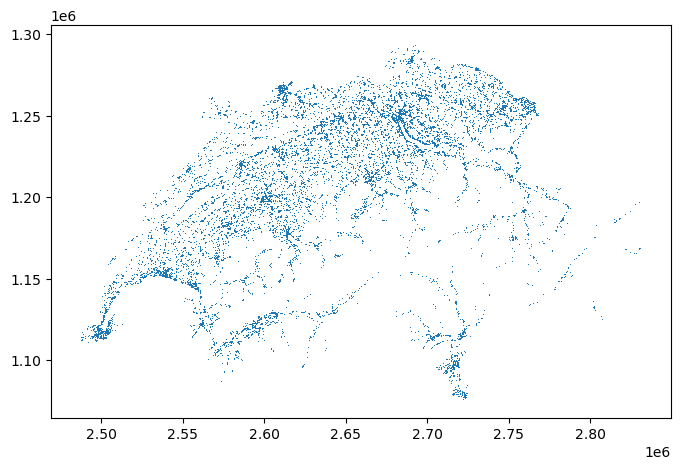

In [8]:
#Ein Geodataframe erstellen mit Polygonen welches aus den vier Punkten einer Rasterzelle bestehen.
gdf= gpd.GeoDataFrame(
    statpoptot.groupby("RELI").apply(
        lambda d: pd.Series(
            {
                "geometry": shapely.geometry.Polygon(
                    d.loc[:, ["E_KOORD", "N_KOORD"]].values
                ),
            }
        )
    )
,crs="EPSG:2056")
gdf.plot(markersize=.1, figsize=(8, 8))

In [9]:
#Mit initialem Dataframe zusammenführen um die Anzahl Einwohner zu erhalten.
StatpopRaster = pd.merge(gdf, statpop, on='RELI')
StatpopRaster

,RELI,geometry,E_KOORD,N_KOORD,B21BTOT
0,48621113,"POLYGON ((2486200.000 1111300.000, 2486300.000...",2486200,1111300,3
1,48621114,"POLYGON ((2486200.000 1111400.000, 2486300.000...",2486200,1111400,5
2,48621115,"POLYGON ((2486200.000 1111500.000, 2486300.000...",2486200,1111500,3
3,48631114,"POLYGON ((2486300.000 1111400.000, 2486400.000...",2486300,1111400,4
4,48631115,"POLYGON ((2486300.000 1111500.000, 2486400.000...",2486300,1111500,3
...,...,...,...,...,...
346832,83101690,"POLYGON ((2831000.000 1169000.000, 2831100.000...",2831000,1169000,5
346833,83101692,"POLYGON ((2831000.000 1169200.000, 2831100.000...",2831000,1169200,3
346834,83111692,"POLYGON ((2831100.000 1169200.000, 2831200.000...",2831100,1169200,3
346835,83111693,"POLYGON ((2831100.000 1169300.000, 2831200.000...",2831100,1169300,13


In [10]:
#in WGS84 transformieren
StatpopRaster = StatpopRaster.to_crs(epsg='4326')
StatpopRaster

,RELI,geometry,E_KOORD,N_KOORD,B21BTOT
0,48621113,"POLYGON ((5.96582 46.14355, 5.96711 46.14357, ...",2486200,1111300,3
1,48621114,"POLYGON ((5.96580 46.14445, 5.96709 46.14447, ...",2486200,1111400,5
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3
3,48631114,"POLYGON ((5.96709 46.14447, 5.96838 46.14449, ...",2486300,1111400,4
4,48631115,"POLYGON ((5.96707 46.14537, 5.96836 46.14539, ...",2486300,1111500,3
...,...,...,...,...,...
346832,83101690,"POLYGON ((10.45592 46.63227, 10.45722 46.63223...",2831000,1169000,5
346833,83101692,"POLYGON ((10.45602 46.63406, 10.45732 46.63403...",2831000,1169200,3
346834,83111692,"POLYGON ((10.45732 46.63403, 10.45863 46.63399...",2831100,1169200,3
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13


# 2. GWR Gebäudedaten aufbereiten

In [11]:
# GWR-Daten Gebäude einlesen und erste Zeilen anschauen
gwr = urlopen("https://public.madd.bfs.admin.ch/ch.zip")

# ZIP-File herunterladen und Dataframe erstellen
zipfile = ZipFile(BytesIO(gwr.read()))
Gebaeude = pd.read_csv(zipfile.open('gebaeude_batiment_edificio.csv'), 
                     sep='\t',
                     usecols = ['GGDENR','GGDENAME','GKODE','GKODN','GKAT','GENH1','GEBF','GAREA','GBAUJ'])

Gebaeude.head()


# GWR-Daten Gebäude einlesen und erste Zeilen anschauen

#Gebaeude = pd.read_csv(r'C:\Users\AninaNico\Documents\CAS_SpatialDataAnalytics\Zertifikatsarbeit\Uebung\Daten\GWR/gebaeude_batiment_edificio.csv',
#                sep='\t',
#                usecols = ['GGDENR','GGDENAME','GKODE','GKODN','GKAT','GENH1','GEBF','GAREA','GBAUJ'])
#Gebaeude.head()

,GGDENR,GGDENAME,GKODE,GKODN,GKAT,GBAUJ,GAREA,GEBF,GENH1
0,1,Aeugst am Albis,2679647.268,1237500.347,1020.0,2000.0,166.0,NaN,7530.0
1,1,Aeugst am Albis,2680635.900,1236936.229,1020.0,2000.0,90.0,NaN,7530.0
2,1,Aeugst am Albis,2679016.828,1235828.156,1020.0,1993.0,72.0,NaN,7530.0
3,1,Aeugst am Albis,2679677.869,1237453.256,1020.0,1845.0,165.0,NaN,7530.0
4,1,Aeugst am Albis,2679692.997,1237491.284,1030.0,1900.0,313.0,NaN,7530.0


# Energiequellen mit NaN als "Unbestimmt" weiter verwenden.

In [12]:
# Die korrekten Bezeichnungen den Heizcodes zuweisen und als Liste speichern.
Gebaeude['Energiequelle'] = Gebaeude.GENH1.replace({
                                            7500: 'Keine',
                                            7501: 'Weitere',
                                            7510: 'Weitere',
                                            7511: 'Weitere',
                                            7512: 'Weitere',
                                            7513: 'Weitere',
                                            7520: 'Gas',
                                            7530: 'Heizöl',
                                            7540: 'Weitere',
                                            7541: 'Weitere',
                                            7542: 'Weitere',
                                            7543: 'Weitere',
                                            7550: 'Weitere',
                                            7560: 'Elektrizität',
                                            7570: 'Weitere',
                                            7580: 'Weitere',
                                            7581: 'Weitere',
                                            7582: 'Weitere',
                                            7598: 'Unbestimmt',
                                            7599: 'Keine'
                                            })

In [13]:
# NULL Werte bei der Energiequelle werden zu "Unbestimmt" gemappt
Gebaeude['Energiequelle'] = Gebaeude['Energiequelle'].fillna('Unbestimmt')
Gebaeude

,GGDENR,GGDENAME,GKODE,GKODN,GKAT,GBAUJ,GAREA,GEBF,GENH1,Energiequelle
0,1,Aeugst am Albis,2679647.268,1237500.347,1020.0,2000.0,166.0,NaN,7530.0,Heizöl
1,1,Aeugst am Albis,2680635.900,1236936.229,1020.0,2000.0,90.0,NaN,7530.0,Heizöl
2,1,Aeugst am Albis,2679016.828,1235828.156,1020.0,1993.0,72.0,NaN,7530.0,Heizöl
3,1,Aeugst am Albis,2679677.869,1237453.256,1020.0,1845.0,165.0,NaN,7530.0,Heizöl
4,1,Aeugst am Albis,2679692.997,1237491.284,1030.0,1900.0,313.0,NaN,7530.0,Heizöl
...,...,...,...,...,...,...,...,...,...,...
3069089,6810,La Baroche,2582768.637,1251359.261,1020.0,NaN,85.0,NaN,7530.0,Heizöl
3069090,6810,La Baroche,2582743.072,1251406.135,1040.0,NaN,172.0,NaN,7530.0,Heizöl
3069091,6810,La Baroche,2584600.501,1251495.804,1020.0,NaN,71.0,NaN,7520.0,Gas
3069092,6810,La Baroche,2583393.948,1251448.443,1020.0,NaN,83.0,NaN,7540.0,Weitere


In [14]:
#Gebäude ohne Wohnnutzung (GKAT=1060) werden rausgefiltert
Wohngebaeude = Gebaeude.query('GKAT in[1010, 1020, 1030, 1040, 1080]')
Wohngebaeude

,GGDENR,GGDENAME,GKODE,GKODN,GKAT,GBAUJ,GAREA,GEBF,GENH1,Energiequelle
0,1,Aeugst am Albis,2679647.268,1237500.347,1020.0,2000.0,166.0,NaN,7530.0,Heizöl
1,1,Aeugst am Albis,2680635.900,1236936.229,1020.0,2000.0,90.0,NaN,7530.0,Heizöl
2,1,Aeugst am Albis,2679016.828,1235828.156,1020.0,1993.0,72.0,NaN,7530.0,Heizöl
3,1,Aeugst am Albis,2679677.869,1237453.256,1020.0,1845.0,165.0,NaN,7530.0,Heizöl
4,1,Aeugst am Albis,2679692.997,1237491.284,1030.0,1900.0,313.0,NaN,7530.0,Heizöl
...,...,...,...,...,...,...,...,...,...,...
3069089,6810,La Baroche,2582768.637,1251359.261,1020.0,NaN,85.0,NaN,7530.0,Heizöl
3069090,6810,La Baroche,2582743.072,1251406.135,1040.0,NaN,172.0,NaN,7530.0,Heizöl
3069091,6810,La Baroche,2584600.501,1251495.804,1020.0,NaN,71.0,NaN,7520.0,Gas
3069092,6810,La Baroche,2583393.948,1251448.443,1020.0,NaN,83.0,NaN,7540.0,Weitere


In [15]:
Wohngebaeude.isnull().sum()

GGDENR                 0
GGDENAME               0
GKODE                515
GKODN                515
GKAT                   0
GBAUJ             927036
GAREA              69093
GEBF             1824175
GENH1             100960
Energiequelle          0
dtype: int64

In [16]:
# Gebäude nur bis Baujahr 2021 und unbekannt werden berücksichtigt, weil die aktuellsten Statpopdaten den Datenstand 31.12.2021 haben.
Wohngebaeude = Wohngebaeude.loc[Wohngebaeude['GBAUJ']!=2022]
Wohngebaeude


,GGDENR,GGDENAME,GKODE,GKODN,GKAT,GBAUJ,GAREA,GEBF,GENH1,Energiequelle
0,1,Aeugst am Albis,2679647.268,1237500.347,1020.0,2000.0,166.0,NaN,7530.0,Heizöl
1,1,Aeugst am Albis,2680635.900,1236936.229,1020.0,2000.0,90.0,NaN,7530.0,Heizöl
2,1,Aeugst am Albis,2679016.828,1235828.156,1020.0,1993.0,72.0,NaN,7530.0,Heizöl
3,1,Aeugst am Albis,2679677.869,1237453.256,1020.0,1845.0,165.0,NaN,7530.0,Heizöl
4,1,Aeugst am Albis,2679692.997,1237491.284,1030.0,1900.0,313.0,NaN,7530.0,Heizöl
...,...,...,...,...,...,...,...,...,...,...
3069089,6810,La Baroche,2582768.637,1251359.261,1020.0,NaN,85.0,NaN,7530.0,Heizöl
3069090,6810,La Baroche,2582743.072,1251406.135,1040.0,NaN,172.0,NaN,7530.0,Heizöl
3069091,6810,La Baroche,2584600.501,1251495.804,1020.0,NaN,71.0,NaN,7520.0,Gas
3069092,6810,La Baroche,2583393.948,1251448.443,1020.0,NaN,83.0,NaN,7540.0,Weitere


In [17]:
#Geodataframe mit den Wohngebäuden aus dem GWR erstellen.
Wohngebaeude_gdf = gpd.GeoDataFrame(
    Wohngebaeude, geometry=gpd.points_from_xy(Wohngebaeude.GKODE, Wohngebaeude.GKODN,crs="EPSG:2056"))

Wohngebaeude_gdf

,GGDENR,GGDENAME,GKODE,GKODN,GKAT,GBAUJ,GAREA,GEBF,GENH1,Energiequelle,geometry
0,1,Aeugst am Albis,2679647.268,1237500.347,1020.0,2000.0,166.0,NaN,7530.0,Heizöl,POINT (2679647.268 1237500.347)
1,1,Aeugst am Albis,2680635.900,1236936.229,1020.0,2000.0,90.0,NaN,7530.0,Heizöl,POINT (2680635.900 1236936.229)
2,1,Aeugst am Albis,2679016.828,1235828.156,1020.0,1993.0,72.0,NaN,7530.0,Heizöl,POINT (2679016.828 1235828.156)
3,1,Aeugst am Albis,2679677.869,1237453.256,1020.0,1845.0,165.0,NaN,7530.0,Heizöl,POINT (2679677.869 1237453.256)
4,1,Aeugst am Albis,2679692.997,1237491.284,1030.0,1900.0,313.0,NaN,7530.0,Heizöl,POINT (2679692.997 1237491.284)
...,...,...,...,...,...,...,...,...,...,...,...
3069089,6810,La Baroche,2582768.637,1251359.261,1020.0,NaN,85.0,NaN,7530.0,Heizöl,POINT (2582768.637 1251359.261)
3069090,6810,La Baroche,2582743.072,1251406.135,1040.0,NaN,172.0,NaN,7530.0,Heizöl,POINT (2582743.072 1251406.135)
3069091,6810,La Baroche,2584600.501,1251495.804,1020.0,NaN,71.0,NaN,7520.0,Gas,POINT (2584600.501 1251495.804)
3069092,6810,La Baroche,2583393.948,1251448.443,1020.0,NaN,83.0,NaN,7540.0,Weitere,POINT (2583393.948 1251448.443)


In [18]:
#Geodataframe mit Wohngebäuden in wGS84 transformieren.
Wohngebaeude_gdf = Wohngebaeude_gdf.to_crs(epsg='4326')

<AxesSubplot: >

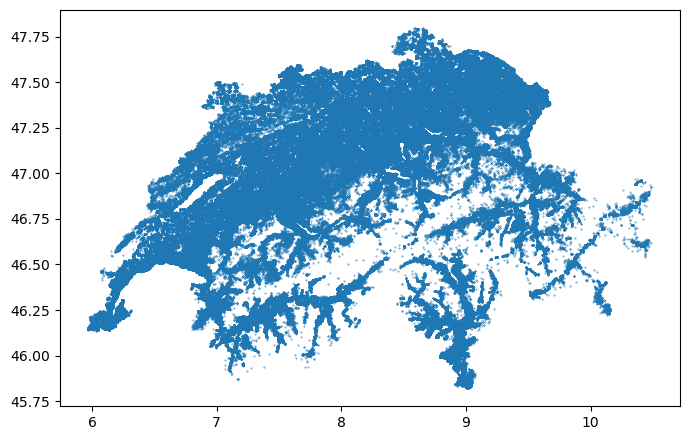

In [19]:
Wohngebaeude_gdf.plot(markersize=.1, figsize=(8, 8))

In [20]:
#Spatial Join der Wohnbevölkerung im Hektarraster (StatpopRaster) und der Wohngebäude aus dem GWR (Wohngebaeude_gdf)
dfsjoin = gpd.sjoin(StatpopRaster, Wohngebaeude_gdf) 

In [21]:
dfsjoin

,RELI,geometry,E_KOORD,N_KOORD,B21BTOT,index_right,GGDENR,GGDENAME,GKODE,GKODN,GKAT,GBAUJ,GAREA,GEBF,GENH1,Energiequelle
0,48621113,"POLYGON ((5.96582 46.14355, 5.96711 46.14357, ...",2486200,1111300,3,2972629,6611,Chancy,2486216.250,1111388.380,1030.0,1907.0,137.0,NaN,7530.0,Heizöl
1,48621114,"POLYGON ((5.96580 46.14445, 5.96709 46.14447, ...",2486200,1111400,5,2972628,6611,Chancy,2486220.750,1111411.190,1020.0,NaN,190.0,NaN,7530.0,Heizöl
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,2972627,6611,Chancy,2486262.500,1111523.750,1020.0,NaN,66.0,NaN,7530.0,Heizöl
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,2972626,6611,Chancy,2486266.500,1111530.440,1020.0,NaN,89.0,NaN,7530.0,Heizöl
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,2972632,6611,Chancy,2486295.750,1111580.130,1020.0,NaN,82.0,NaN,7540.0,Weitere
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,1893150,3847,Val Müstair,2831159.612,1169317.534,1030.0,1940.0,70.0,NaN,7530.0,Heizöl
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,1892650,3847,Val Müstair,2831127.398,1169327.474,1020.0,1960.0,173.0,NaN,7530.0,Heizöl
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,1892648,3847,Val Müstair,2831158.578,1169342.603,1040.0,NaN,224.0,NaN,7530.0,Heizöl
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,1892649,3847,Val Müstair,2831144.784,1169350.606,1020.0,1960.0,172.0,NaN,7530.0,Heizöl


In [22]:
# Pivottabelle erstellen
# Damit erhalte ich für jede Hektarrasterzelle aus dem Statpop (id=RELI) die Anzahl Gebäude nach Energiequelle.
dfpivot = pd.pivot_table(dfsjoin,index='RELI',columns='Energiequelle',aggfunc={'Energiequelle':len})
dfpivot.columns = dfpivot.columns.droplevel()
dfpivot

Energiequelle,Elektrizität,Gas,Heizöl,Keine,Unbestimmt,Weitere
RELI,,,,,,
48621113,NaN,NaN,1.0,NaN,NaN,NaN
48621114,NaN,NaN,1.0,NaN,NaN,NaN
48621115,NaN,NaN,2.0,NaN,NaN,1.0
48631114,NaN,NaN,NaN,NaN,1.0,NaN
48631115,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...
83101690,NaN,NaN,1.0,NaN,NaN,NaN
83101692,1.0,NaN,NaN,NaN,NaN,1.0
83111692,NaN,NaN,1.0,NaN,NaN,NaN


In [23]:
# Nun wird die Pivottabelle mit dem Geodatenframe (StatpopRaster) gemergt. 
EnergiequellenRaster = StatpopRaster.merge(dfpivot, how='left', on='RELI')
EnergiequellenRaster

,RELI,geometry,E_KOORD,N_KOORD,B21BTOT,Elektrizität,Gas,Heizöl,Keine,Unbestimmt,Weitere
0,48621113,"POLYGON ((5.96582 46.14355, 5.96711 46.14357, ...",2486200,1111300,3,NaN,NaN,1.0,NaN,NaN,NaN
1,48621114,"POLYGON ((5.96580 46.14445, 5.96709 46.14447, ...",2486200,1111400,5,NaN,NaN,1.0,NaN,NaN,NaN
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,NaN,NaN,2.0,NaN,NaN,1.0
3,48631114,"POLYGON ((5.96709 46.14447, 5.96838 46.14449, ...",2486300,1111400,4,NaN,NaN,NaN,NaN,1.0,NaN
4,48631115,"POLYGON ((5.96707 46.14537, 5.96836 46.14539, ...",2486300,1111500,3,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
346832,83101690,"POLYGON ((10.45592 46.63227, 10.45722 46.63223...",2831000,1169000,5,NaN,NaN,1.0,NaN,NaN,NaN
346833,83101692,"POLYGON ((10.45602 46.63406, 10.45732 46.63403...",2831000,1169200,3,1.0,NaN,NaN,NaN,NaN,1.0
346834,83111692,"POLYGON ((10.45732 46.63403, 10.45863 46.63399...",2831100,1169200,3,NaN,NaN,1.0,NaN,NaN,NaN
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,NaN,NaN,5.0,NaN,NaN,1.0


In [24]:
# Prüfen ob noch NULL Werte vorhanden sind.
EnergiequellenRaster.isnull().sum()

RELI                 0
geometry             0
E_KOORD              0
N_KOORD              0
B21BTOT              0
Elektrizität    276935
Gas             262771
Heizöl          115155
Keine           330239
Unbestimmt      199711
Weitere         178381
dtype: int64

In [25]:
# Die NULL Werte werden mit 0 ersetzt.
EnergiequellenRaster = EnergiequellenRaster.fillna(0)
EnergiequellenRaster


,RELI,geometry,E_KOORD,N_KOORD,B21BTOT,Elektrizität,Gas,Heizöl,Keine,Unbestimmt,Weitere
0,48621113,"POLYGON ((5.96582 46.14355, 5.96711 46.14357, ...",2486200,1111300,3,0.0,0.0,1.0,0.0,0.0,0.0
1,48621114,"POLYGON ((5.96580 46.14445, 5.96709 46.14447, ...",2486200,1111400,5,0.0,0.0,1.0,0.0,0.0,0.0
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,0.0,0.0,2.0,0.0,0.0,1.0
3,48631114,"POLYGON ((5.96709 46.14447, 5.96838 46.14449, ...",2486300,1111400,4,0.0,0.0,0.0,0.0,1.0,0.0
4,48631115,"POLYGON ((5.96707 46.14537, 5.96836 46.14539, ...",2486300,1111500,3,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
346832,83101690,"POLYGON ((10.45592 46.63227, 10.45722 46.63223...",2831000,1169000,5,0.0,0.0,1.0,0.0,0.0,0.0
346833,83101692,"POLYGON ((10.45602 46.63406, 10.45732 46.63403...",2831000,1169200,3,1.0,0.0,0.0,0.0,0.0,1.0
346834,83111692,"POLYGON ((10.45732 46.63403, 10.45863 46.63399...",2831100,1169200,3,0.0,0.0,1.0,0.0,0.0,0.0
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,0.0,0.0,5.0,0.0,0.0,1.0


In [26]:
#Die Anzahl Gebäude pro Hektarraster zählen
EnergiequellenRaster['AnzahlGebaeude'] = EnergiequellenRaster['Elektrizität'] + EnergiequellenRaster['Gas'] + EnergiequellenRaster['Heizöl'] + EnergiequellenRaster['Keine'] + EnergiequellenRaster['Unbestimmt'] + + EnergiequellenRaster['Weitere']

In [27]:
EnergiequellenRaster

,RELI,geometry,E_KOORD,N_KOORD,B21BTOT,Elektrizität,Gas,Heizöl,Keine,Unbestimmt,Weitere,AnzahlGebaeude
0,48621113,"POLYGON ((5.96582 46.14355, 5.96711 46.14357, ...",2486200,1111300,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,48621114,"POLYGON ((5.96580 46.14445, 5.96709 46.14447, ...",2486200,1111400,5,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,0.0,0.0,2.0,0.0,0.0,1.0,3.0
3,48631114,"POLYGON ((5.96709 46.14447, 5.96838 46.14449, ...",2486300,1111400,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,48631115,"POLYGON ((5.96707 46.14537, 5.96836 46.14539, ...",2486300,1111500,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
346832,83101690,"POLYGON ((10.45592 46.63227, 10.45722 46.63223...",2831000,1169000,5,0.0,0.0,1.0,0.0,0.0,0.0,1.0
346833,83101692,"POLYGON ((10.45602 46.63406, 10.45732 46.63403...",2831000,1169200,3,1.0,0.0,0.0,0.0,0.0,1.0,2.0
346834,83111692,"POLYGON ((10.45732 46.63403, 10.45863 46.63399...",2831100,1169200,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,0.0,0.0,5.0,0.0,0.0,1.0,6.0


In [28]:
# Die Anzahl Einwohner aus der STATPOP werden nun proportional auf die Gebäude verteilt innerhalb einer Hektarrasterzelle
EnergiequellenRaster['PaxElektrizität'] = EnergiequellenRaster['B21BTOT']/EnergiequellenRaster['AnzahlGebaeude']*EnergiequellenRaster['Elektrizität']
EnergiequellenRaster['PaxGas'] = EnergiequellenRaster['B21BTOT']/EnergiequellenRaster['AnzahlGebaeude']*EnergiequellenRaster['Gas']
EnergiequellenRaster['PaxÖl'] = EnergiequellenRaster['B21BTOT']/EnergiequellenRaster['AnzahlGebaeude']*EnergiequellenRaster['Heizöl']
EnergiequellenRaster['PaxKeine'] = EnergiequellenRaster['B21BTOT']/EnergiequellenRaster['AnzahlGebaeude']*EnergiequellenRaster['Keine']
EnergiequellenRaster['PaxUnbestimmt'] = EnergiequellenRaster['B21BTOT']/EnergiequellenRaster['AnzahlGebaeude']*EnergiequellenRaster['Unbestimmt']
EnergiequellenRaster['PaxWeitere'] = EnergiequellenRaster['B21BTOT']/EnergiequellenRaster['AnzahlGebaeude']*EnergiequellenRaster['Weitere']


In [29]:
# Die NULL Werte werden mit 0 ersetzt. Muss noch einmal gemacht werden weil bei einigen wenigen Rasterzellen die AnzahlGebaeude = 0 ist was in einer Dividierung durch 0 entspricht
EnergiequellenRaster = EnergiequellenRaster.fillna(0)
EnergiequellenRaster

,RELI,geometry,E_KOORD,N_KOORD,B21BTOT,Elektrizität,Gas,Heizöl,Keine,Unbestimmt,Weitere,AnzahlGebaeude,PaxElektrizität,PaxGas,PaxÖl,PaxKeine,PaxUnbestimmt,PaxWeitere
0,48621113,"POLYGON ((5.96582 46.14355, 5.96711 46.14357, ...",2486200,1111300,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.000000,0.0,0.0,0.000000
1,48621114,"POLYGON ((5.96580 46.14445, 5.96709 46.14447, ...",2486200,1111400,5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.000000,0.0,0.0,0.000000
2,48621115,"POLYGON ((5.96577 46.14535, 5.96707 46.14537, ...",2486200,1111500,3,0.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,2.000000,0.0,0.0,1.000000
3,48631114,"POLYGON ((5.96709 46.14447, 5.96838 46.14449, ...",2486300,1111400,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,4.0,0.000000
4,48631115,"POLYGON ((5.96707 46.14537, 5.96836 46.14539, ...",2486300,1111500,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346832,83101690,"POLYGON ((10.45592 46.63227, 10.45722 46.63223...",2831000,1169000,5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.000000,0.0,0.0,0.000000
346833,83101692,"POLYGON ((10.45602 46.63406, 10.45732 46.63403...",2831000,1169200,3,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.5,0.0,0.000000,0.0,0.0,1.500000
346834,83111692,"POLYGON ((10.45732 46.63403, 10.45863 46.63399...",2831100,1169200,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.000000,0.0,0.0,0.000000
346835,83111693,"POLYGON ((10.45737 46.63493, 10.45868 46.63489...",2831100,1169300,13,0.0,0.0,5.0,0.0,0.0,1.0,6.0,0.0,0.0,10.833333,0.0,0.0,2.166667


In [30]:
# Dataframe entschlacken d.h. Die nicht verwendeten Attribute löschen
PaxPerEnergieRaster = EnergiequellenRaster.drop(['E_KOORD','N_KOORD','B21BTOT','Elektrizität','Gas','Heizöl','Keine','Weitere','AnzahlGebaeude','RELI','Unbestimmt'], axis=1)

# 3. Hektarraster einer Gemeinde zuweisen

In [31]:
# Fehlermeldung kann ignoriert werden weil es sich bei den Polygonen um einfache Quadrate handelt.
# Für jede Rasterzelle wird der Mittelpunkt ermittelt.
PaxPerEnergieRaster['geometry'] = PaxPerEnergieRaster.centroid

/tmp/ipykernel_32105/1839232027.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  PaxPerEnergieRaster['geometry'] = PaxPerEnergieRaster.centroid


In [32]:
PaxPerEnergieRaster

,geometry,PaxElektrizität,PaxGas,PaxÖl,PaxKeine,PaxUnbestimmt,PaxWeitere
0,POINT (5.96645 46.14401),0.0,0.0,3.000000,0.0,0.0,0.000000
1,POINT (5.96643 46.14491),0.0,0.0,5.000000,0.0,0.0,0.000000
2,POINT (5.96641 46.14581),0.0,0.0,2.000000,0.0,0.0,1.000000
3,POINT (5.96772 46.14493),0.0,0.0,0.000000,0.0,4.0,0.000000
4,POINT (5.96770 46.14583),0.0,0.0,0.000000,0.0,3.0,0.000000
...,...,...,...,...,...,...,...
346832,POINT (10.45659 46.63270),0.0,0.0,5.000000,0.0,0.0,0.000000
346833,POINT (10.45670 46.63450),1.5,0.0,0.000000,0.0,0.0,1.500000
346834,POINT (10.45800 46.63446),0.0,0.0,3.000000,0.0,0.0,0.000000
346835,POINT (10.45805 46.63536),0.0,0.0,10.833333,0.0,0.0,2.166667


In [33]:
PaxPerEnergieRaster.isnull().sum()

geometry           0
PaxElektrizität    0
PaxGas             0
PaxÖl              0
PaxKeine           0
PaxUnbestimmt      0
PaxWeitere         0
dtype: int64

In [34]:
# Die aktuellsten Gemeindegrenzen über die STAC API herunterladen

# Anfragen welche Files verfügbar sind.
StacApiUrl = requests.get('https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissboundaries3d/items')
StacApiAntwortJson = json.loads(StacApiUrl.text)
StacApiAntwort = StacApiAntwortJson['features']
StacApiAntwort

[{'id': 'swissboundaries3d_2021-01',
  'collection': 'ch.swisstopo.swissboundaries3d',
  'type': 'Feature',
  'stac_version': '0.9.0',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[5.3385875, 45.3594856],
     [5.2229406, 48.2425816],
     [11.2575962, 48.2013771],
     [11.0586366, 45.3204053],
     [5.3385875, 45.3594856]]]},
  'bbox': [5.2229406, 45.3204053, 11.2575962, 48.2425816],
  'properties': {'datetime': '2021-01-01T00:00:00Z',
   'created': '2021-07-12T14:09:43.800221Z',
   'updated': '2021-07-12T14:20:45.851774Z'},
  'links': [{'rel': 'self',
    'href': 'https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissboundaries3d/items/swissboundaries3d_2021-01'},
   {'rel': 'root', 'href': 'https://data.geo.admin.ch/api/stac/v0.9/'},
   {'rel': 'parent',
    'href': 'https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissboundaries3d'},
   {'rel': 'collection',
    'href': 'https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swis

In [35]:
# Die Antwort in ein Dataframe schreiben und das Datum als Zeitstempel speichern.
StacJsonAntwort = pd.json_normalize(StacApiAntwort)
StacJsonAntwort = StacJsonAntwort[['id','properties.datetime']]
StacJsonAntwort['properties.datetime'] = pd.to_datetime(StacJsonAntwort['properties.datetime'])
StacJsonAntwort

,id,properties.datetime
0,swissboundaries3d_2021-01,2021-01-01 00:00:00+00:00
1,swissboundaries3d_2021-04,2021-04-18 00:00:00+00:00
2,swissboundaries3d_2021-07,2021-07-01 00:00:00+00:00
3,swissboundaries3d_2022-01,2022-01-01 00:00:00+00:00
4,swissboundaries3d_2022-05,2022-05-01 00:00:00+00:00


In [36]:
# Zeitstempel des aktuellsten Files rausfiltern
Zeitstempel = StacJsonAntwort.max().id
Zeitstempel

'swissboundaries3d_2022-05'

In [38]:
# Aktuellstes File herunterladen und entzippen
datenurl = 'https://data.geo.admin.ch/ch.swisstopo.swissboundaries3d/' + Zeitstempel + '/' + Zeitstempel + '_2056_5728.gdb.zip'
r = requests.get(datenurl)
open('Gemeinde/Gemeindegrenzen.zip','wb').write(r.content)

with ZipFile('Gemeinde/Gemeindegrenzen.zip', 'r') as zip_ref:
    zip_ref.extractall('Gemeinde')

In [39]:
#Gemeindegrenzen reinladen
switzerland_gemeinde = gpd.read_file('Gemeinde/swissBOUNDARIES3D_1_3_LV95_LN02.gdb', layer=3).to_crs(epsg='4326')
switzerland_gemeinde

,UUID,DATUM_AENDERUNG,DATUM_ERSTELLUNG,ERSTELLUNG_JAHR,ERSTELLUNG_MONAT,REVISION_JAHR,REVISION_MONAT,GRUND_AENDERUNG,HERKUNFT,HERKUNFT_JAHR,...,GEM_TEIL,GEM_FLAECHE,SEE_FLAECHE,ICC,SHN,REVISION_QUALITAET,EINWOHNERZAHL,Shape_Length,Shape_Area,geometry
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03 09:12:28+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2020,...,0,43861.0,NaN,CH,CH18433762,2021_Aufbau,4624.0,112473.317556,4.386061e+08,MULTIPOLYGON Z (((10.23251 46.87160 2980.12200...
1,{B55F9EAE-EB69-4468-A41C-7BB28A6699EE},2021-10-26 13:07:34+00:00,2008-11-24 00:00:00+00:00,2006,1,2022,5,400,500,2021,...,0,43003.0,NaN,CH,CH08001631,2021_Aufbau,9480.0,116787.901278,4.300324e+08,"MULTIPOLYGON Z (((8.95776 46.80444 3402.83600,..."
2,{AB2BA4A5-EB8C-40C7-A259-271DAC93C767},2021-10-26 13:07:12+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2021,...,0,34404.0,NaN,CH,CH18433746,2021_Aufbau,1506.0,102012.979193,3.440368e+08,MULTIPOLYGON Z (((10.10516 46.84090 3111.08100...
3,{550D0610-1EE3-4748-8F29-88072753FFDC},2021-10-26 13:07:19+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2021,...,0,32377.0,NaN,CH,CH18413543,2021_Aufbau,2377.0,93629.567857,3.237737e+08,"MULTIPOLYGON Z (((9.49892 46.62472 2730.10000,..."
4,{5B0C1705-1D2B-4E53-9970-6BC3DE33A0F7},2021-10-26 13:07:08+00:00,2008-11-24 00:00:00+00:00,1997,1,2022,5,400,500,2021,...,0,30191.0,NaN,CH,CH23036037,2021_Aufbau,10329.0,106069.364264,3.019118e+08,"MULTIPOLYGON Z (((7.29444 45.92182 3576.25800,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,{7FAC8A17-64F7-4920-B7EC-29A4B4F3630E},2015-12-08 15:34:34+00:00,2008-11-24 00:00:00+00:00,1997,1,2022,5,400,500,2015,...,3,NaN,NaN,CH,CH19094257,2021_Aufbau,NaN,392.427744,6.167572e+03,"MULTIPOLYGON Z (((7.79979 47.49804 482.51200, ..."
2282,{454AF364-1D3A-4EC8-9033-B5FF8320DBB0},2015-12-10 09:35:38+00:00,2008-11-24 00:00:00+00:00,2002,1,2022,5,400,500,2015,...,2,NaN,NaN,CH,CH16003104,2021_Aufbau,NaN,303.496096,5.820701e+03,"MULTIPOLYGON Z (((9.36218 47.38678 783.96600, ..."
2283,{CF0F9771-1C72-4F3D-9476-8D928A01C031},2015-12-10 09:35:33+00:00,2008-11-24 00:00:00+00:00,2002,1,2022,5,400,500,2015,...,3,NaN,NaN,CH,CH16003111,2021_Aufbau,NaN,246.833477,2.789099e+03,"MULTIPOLYGON Z (((9.61262 47.44358 643.66300, ..."
2284,{B9D2A8BB-2A0B-4F54-9200-F9947892E6F1},2021-10-26 13:07:30+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2021,...,0,1830.0,237.0,CH,CH25006621,2021_Aufbau,203856.0,22802.041363,1.829613e+07,"MULTIPOLYGON Z (((6.12765 46.18777 379.24200, ..."


In [40]:
switzerland_gemeinde['NAME']

0                Scuol
1           Glarus Süd
2               Zernez
3               Surses
4        Val de Bagnes
             ...      
2281           Olsberg
2282    Schlatt-Haslen
2283           Oberegg
2284            Genève
2285      Carouge (GE)
Name: NAME, Length: 2286, dtype: object

<AxesSubplot: >

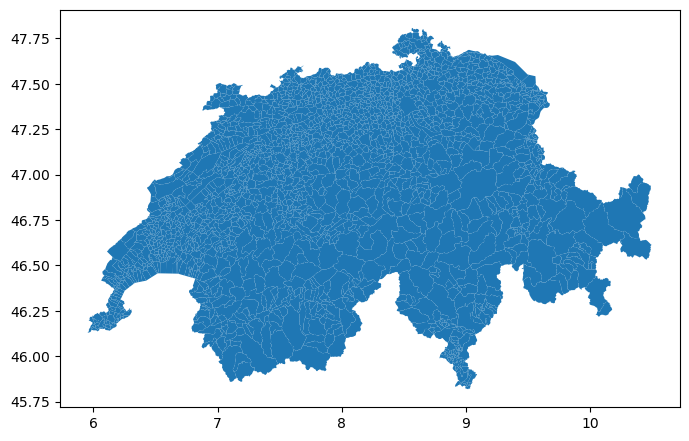

In [41]:
switzerland_gemeinde.plot(markersize=.1, figsize=(8, 8))


In [42]:
#Spatial Join der Wohnbevölkerung im Hektarraster (StatpopRaster) und der Wohngebäude aus dem GWR (Wohngebaeude_gdf)
gemeindejoin = gpd.sjoin(switzerland_gemeinde, PaxPerEnergieRaster)
gemeindejoin

,UUID,DATUM_AENDERUNG,DATUM_ERSTELLUNG,ERSTELLUNG_JAHR,ERSTELLUNG_MONAT,REVISION_JAHR,REVISION_MONAT,GRUND_AENDERUNG,HERKUNFT,HERKUNFT_JAHR,...,Shape_Length,Shape_Area,geometry,index_right,PaxElektrizität,PaxGas,PaxÖl,PaxKeine,PaxUnbestimmt,PaxWeitere
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03 09:12:28+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2020,...,112473.317556,4.386061e+08,MULTIPOLYGON Z (((10.23251 46.87160 2980.12200...,346440,0.0,0.000000,6.000000,0.0,0.000000,0.0
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03 09:12:28+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2020,...,112473.317556,4.386061e+08,MULTIPOLYGON Z (((10.23251 46.87160 2980.12200...,346557,5.0,0.000000,0.000000,0.0,0.000000,0.0
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03 09:12:28+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2020,...,112473.317556,4.386061e+08,MULTIPOLYGON Z (((10.23251 46.87160 2980.12200...,346434,0.0,0.000000,2.333333,0.0,11.666667,7.0
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03 09:12:28+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2020,...,112473.317556,4.386061e+08,MULTIPOLYGON Z (((10.23251 46.87160 2980.12200...,346431,1.0,1.000000,0.000000,0.0,2.000000,0.0
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2020-11-03 09:12:28+00:00,2008-11-24 00:00:00+00:00,2000,1,2022,5,400,500,2020,...,112473.317556,4.386061e+08,MULTIPOLYGON Z (((10.23251 46.87160 2980.12200...,346496,0.0,0.000000,0.000000,0.0,6.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,{D7E8A67B-13C5-46F6-B572-060AD44C3F27},2021-10-26 13:07:19+00:00,2008-11-24 00:00:00+00:00,1997,1,2022,5,400,500,2021,...,8991.988013,2.696751e+06,"MULTIPOLYGON Z (((6.12765 46.18777 379.24200, ...",3493,0.0,53.250000,17.750000,0.0,0.000000,0.0
2285,{D7E8A67B-13C5-46F6-B572-060AD44C3F27},2021-10-26 13:07:19+00:00,2008-11-24 00:00:00+00:00,1997,1,2022,5,400,500,2021,...,8991.988013,2.696751e+06,"MULTIPOLYGON Z (((6.12765 46.18777 379.24200, ...",3578,0.0,37.583333,0.000000,0.0,3.416667,0.0
2285,{D7E8A67B-13C5-46F6-B572-060AD44C3F27},2021-10-26 13:07:19+00:00,2008-11-24 00:00:00+00:00,1997,1,2022,5,400,500,2021,...,8991.988013,2.696751e+06,"MULTIPOLYGON Z (((6.12765 46.18777 379.24200, ...",3492,0.0,0.000000,3.000000,0.0,0.000000,0.0
2285,{D7E8A67B-13C5-46F6-B572-060AD44C3F27},2021-10-26 13:07:19+00:00,2008-11-24 00:00:00+00:00,1997,1,2022,5,400,500,2021,...,8991.988013,2.696751e+06,"MULTIPOLYGON Z (((6.12765 46.18777 379.24200, ...",3577,0.0,27.428571,4.571429,0.0,0.000000,0.0


In [43]:
# Zählt alle Gebäude pro Gemeinde, Bauperiode und Energiequelle
Gemeindeliste = gemeindejoin[['PaxGas','PaxÖl','PaxElektrizität','PaxKeine','PaxUnbestimmt','PaxWeitere']].sum().reset_index()
Gemeindeliste

,index,0
0,PaxGas,2.018858e+06
1,PaxÖl,3.380076e+06
2,PaxElektrizität,3.870217e+05
3,PaxKeine,1.502859e+05
4,PaxUnbestimmt,1.421563e+06
5,PaxWeitere,1.442623e+06


In [44]:
GemeindeEinwohner = gemeindejoin.groupby(['NAME'])['PaxGas','PaxÖl','PaxKeine','PaxUnbestimmt','PaxWeitere'].agg('sum')

/tmp/ipykernel_32105/4213906229.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  GemeindeEinwohner = gemeindejoin.groupby(['NAME'])['PaxGas','PaxÖl','PaxKeine','PaxUnbestimmt','PaxWeitere'].agg('sum')


In [45]:
GemeindeEinwohner

,PaxGas,PaxÖl,PaxKeine,PaxUnbestimmt,PaxWeitere
NAME,,,,,
Aadorf,3052.745244,2994.955013,21.145022,1386.272859,1591.391402
Aarau,8276.148334,8298.592317,11.721612,2884.107022,1595.191515
Aarberg,796.592051,1992.827463,22.046154,1276.457763,308.869334
Aarburg,3090.971294,3018.498624,16.438462,1706.718669,600.823469
Aarwangen,94.700396,2544.096628,26.671717,1324.753096,615.672094
...,...,...,...,...,...
Zwingen,30.766667,1250.563730,472.163987,0.000000,745.780723
Zwischbergen,0.000000,0.933333,2.333333,0.000000,14.666667
Zäziwil,0.000000,735.861469,31.430769,322.272552,448.119841


In [46]:
# Werte auf Ganzzahlen runden
GemeindeEinwohner = round(GemeindeEinwohner).reset_index()
GemeindeEinwohner

,NAME,PaxGas,PaxÖl,PaxKeine,PaxUnbestimmt,PaxWeitere
0,Aadorf,3053.0,2995.0,21.0,1386.0,1591.0
1,Aarau,8276.0,8299.0,12.0,2884.0,1595.0
2,Aarberg,797.0,1993.0,22.0,1276.0,309.0
3,Aarburg,3091.0,3018.0,16.0,1707.0,601.0
4,Aarwangen,95.0,2544.0,27.0,1325.0,616.0
...,...,...,...,...,...,...
2148,Zwingen,31.0,1251.0,472.0,0.0,746.0
2149,Zwischbergen,0.0,1.0,2.0,0.0,15.0
2150,Zäziwil,0.0,736.0,31.0,322.0,448.0
2151,Zürich,188784.0,98848.0,30439.0,9404.0,95700.0


In [47]:
# Die Spaltennamen des DataFrames neu benennen
GemeindeEinwohner.columns  = ['Gemeinde','PaxGas','PaxÖl','PaxKeine','PaxUnbestimmt','PaxWeitere']

## Daten als CSV-Datei exportieren

In [48]:
# Als CSV-File exportieren
GemeindeEinwohner.to_csv('Daten/Gemeindeliste_1-2.csv', index = False, header=True, sep=',', encoding="utf-8-sig")